# Week 7: Nearest Neighbors, Logistic Regression, and LDA

This week, we will learn about a number of different classification methods that are in common usage, including $k$-nearest-neighbors ($k$-NN), logistic regression, and linear discriminant analysis (LDA). There are further variants of each type although our focus will be on the core approaches.

An array of classifiers are used on a few datasets in this code from [scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

Automatically created module for IPython interactive environment


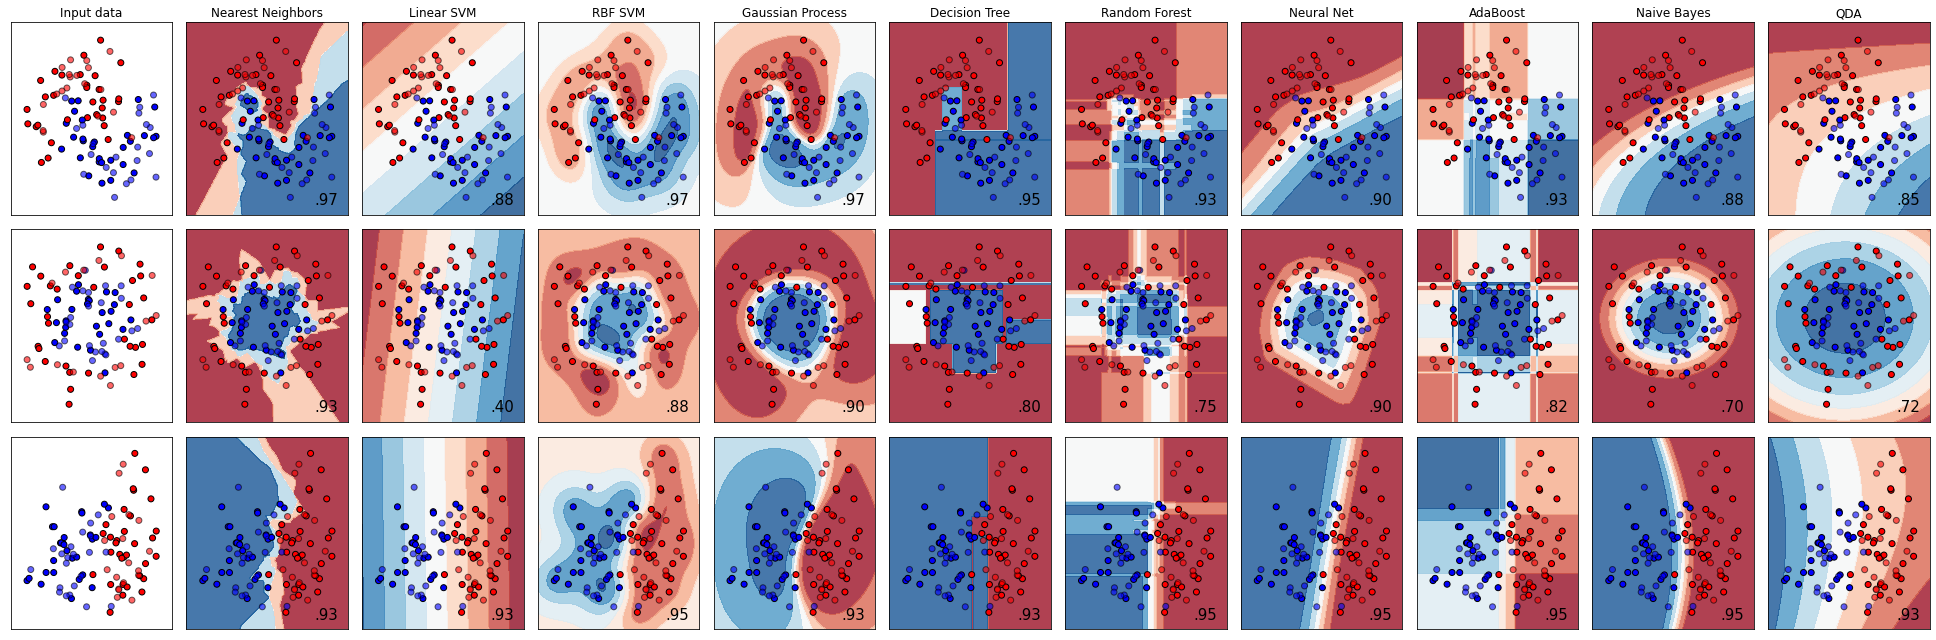

In [1]:
print(__doc__)


# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

Any of the methods above are good choices in some cases, but they each have strengths and weaknesses and work in very different ways. My hope is that you will build enough understanding of classification problems that you will easily be able to deploy any algorithm you choose.

## Lecture 16: $k$-Nearest Neighbors Classifier

The $k$-nearest neighbor classifier tries to classify numerical examples into categories. Suppose we have some labeled examples $x_1, ..., x_n\in\mathbb{R}^d$ with labels $y_1, ..., y_n$. If we have a new, unlabeled point $x$, we would like to predict its class label. The idea of the $k$-nearest neighbor algorithm is that we take the $k$ labeled examples nearest to $x$ and assign the most frequent class of these nearest "neighbors" to $x$.

### The Procedure to Classify an Example $x$ with $k$-Nearest Neighbors

1. Choose a positive integer for $k$.

1. Find the distances $\left\|x-x_j\right\|$ for each $j=1,...,n$ with any norm you choose.

1. Find the points with the $k$ shortest distances from $x$ (the $k$ nearest "neighbors").

1. Assign the most frequent class among the $k$ nearest neighbors to $x$

This means we need to make only two decisions two use the $k$-nearest neighbors: we need to choose a norm and we need to choose the number of neighbors $k$ to use. Customizable parameters for a machine learning method like this $k$-nearest neighbor classifier are called **hyperparameters**. It is not generally obvious how to choose these hyperparameters and it tends to be pretty experimental. Tuning hyperparameters is a large part of machine learning.

### $k$-Nearest Neighbor Code

Let's write some code. I will use the style used by the popular machine learning library <a href="https://scikit-learn.org/stable/">scikit-learn</a>, where a classifier is written as a class in the programming sense (not to be confused with the "classes" of our classification problem) with hyperparameters as inputs. The classifier's class will have some functions that fit the model to the data and predict the class of input datapoints.

The 'fit' function for the $k$-nearest neighbors will do very little but record some data. The 'predict' function will carry out steps 1-4 above.

First, we import some libraries.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

from scipy.stats import mode
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10

In [3]:
# Create a class for the k-nearest neighbor classifier
class kNearestNeighborClassifier:
    # constructor to save the hyperparameter k
    def __init__(self, k = 5):
        # initialize the number of neighbors to use
        self.neighbors = k
    
    # fit the model to the training data (for kNN, there's no actual fitting involved)
    def fit(self, X, y):
            
        # record the data and labels
        self.data = X
        self.labels = y
    
    # use the classifier to predict the classifications of the testing data
    def predict(self, X):
        # initialize the predicted classes
        yPredicted = np.empty([X.shape[0],1])
        
        # loop over the datapoints in X
        for row in range(X.shape[0]):
            datapoint = X[row,]
            
            # find the distances from the datapoint to each training point using the L2 norm
            distances = np.sqrt(np.sum(((self.data - datapoint)**2), axis = 1))
            
            # find the indices of the smallest k distances
            indices = np.argsort(distances)[:self.neighbors]
            
            # find the the class labels of the nearest neighbors
            nearestClasses = self.labels[indices]
            
            # determine the predicted class by finding the mode
            yPredicted[row] = int(mode(nearestClasses)[0][0])
            
        return yPredicted

### Example: Randomly Generated Points

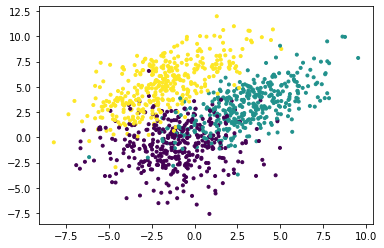

In [4]:
# number of points to generate
numberOfPoints = 500

# generate points from class 0
mean1 = np.array([-1, -1])
covariance1 = np.array([[5, 0], [0, 5]])
X1 = np.random.multivariate_normal(mean1, covariance1, numberOfPoints)

# generate points from class 1
mean2 = np.array([3, 3])
covariance2 = np.array([[5, 3], [3, 5]])
X2 = np.random.multivariate_normal(mean2, covariance2, numberOfPoints)

# generate points from class 2
mean3 = np.array([-2, 5])
covariance3 = np.array([[5, 3], [3, 5]])
X3 = np.random.multivariate_normal(mean3, covariance3, numberOfPoints)

# stack the points
X = np.vstack((X1, X2, X3))

# create a vector of the labels
Y = np.hstack((numberOfPoints * [0], numberOfPoints * [1], numberOfPoints * [2]))

# randomly choose 75% of the data to be the training set and 25% for the testing set
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# plot the training set
plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')


Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.77      0.77       120
           1       0.82      0.78      0.80       127
           2       0.87      0.92      0.89       128

    accuracy                           0.82       375
   macro avg       0.82      0.82      0.82       375
weighted avg       0.82      0.82      0.82       375


Confusion Matrix:



<AxesSubplot:>

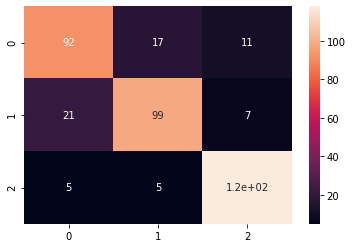

In [5]:
# fit the model to the training data
model = kNearestNeighborClassifier(k = 3)
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

The code above computes the neighbors in a pretty brute-force way, which is pretty slow, so it is generally best to use an existing implementation like `KNeighborsClassifier` in `scikit-learn`.


Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.77      0.77       120
           1       0.82      0.78      0.80       127
           2       0.87      0.92      0.89       128

    accuracy                           0.82       375
   macro avg       0.82      0.82      0.82       375
weighted avg       0.82      0.82      0.82       375


Confusion Matrix:



<AxesSubplot:>

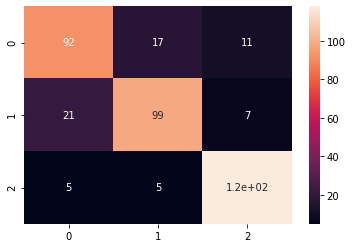

In [6]:
# fit the model to the training data
model = KNeighborsClassifier(3)
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)


Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.76      0.76       120
           1       0.80      0.78      0.79       127
           2       0.87      0.91      0.89       128

    accuracy                           0.82       375
   macro avg       0.81      0.81      0.81       375
weighted avg       0.81      0.82      0.82       375


Confusion Matrix:



<AxesSubplot:>

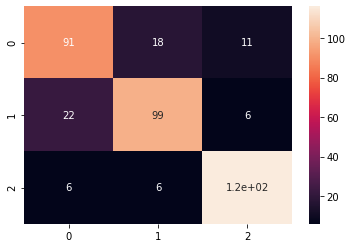

In [7]:
# fit the model to the training data
model = KNeighborsClassifier(n_neighbors = 3, weights = 'distance')
model.fit(trainX,trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

plt.scatter(trainX[:,0], trainX[:,1], c = trainY, marker = '.')

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

### Classifying MNIST Handwritten Digits with $k$-NN

Dev classification accuracy 1 neighbors is 0.865
Dev classification accuracy 2 neighbors is 0.843
Dev classification accuracy 3 neighbors is 0.884
Dev classification accuracy 4 neighbors is 0.871
Dev classification accuracy 5 neighbors is 0.87
Dev classification accuracy 6 neighbors is 0.864
Dev classification accuracy 7 neighbors is 0.864
Dev classification accuracy 8 neighbors is 0.858
Dev classification accuracy 9 neighbors is 0.86
Dev classification accuracy 10 neighbors is 0.852

The best dev accuracy 0.884 occured with 3 neghbors

Test Classification Report for 0.884 neighbors:

               precision    recall  f1-score   support

           0       0.87      0.96      0.91        95
           1       0.87      0.98      0.92       125
           2       0.89      0.84      0.87       108
           3       0.76      0.84      0.80        83
           4       0.87      0.86      0.87       101
           5       0.90      0.76      0.83       100
           6       0.86     

<AxesSubplot:>

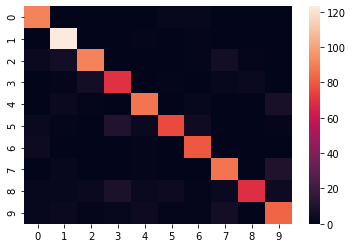

In [8]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2]).astype('float')/255.0
testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2]).astype('float')/255.0

devX, testX, devY, testY = train_test_split(testX, testY, test_size = 0.5)

trainX = trainX[:1000]
devX = devX[:1000]
testX = testX[:1000]
trainY = trainY[:1000]
devY = devY[:1000]
testY = testY[:1000]

bestAccuracy = [0, 0]

for k in range(1, 11):
    # build the knn classifier
    model = KNeighborsClassifier(k)

    # fit the knn classifier to the training data
    model.fit(trainX, trainY)

    # predict the labels of the test set
    predictedY = model.predict(devX)
    
    # compute the accuracy
    acc = accuracy_score(devY, predictedY)
    
    # print quality metrics
    print('Dev classification accuracy', k, 'neighbors is', acc)
    
    # save the hyperparameter k if better than found before
    if acc > bestAccuracy[0]:
        bestAccuracy = [acc, k]
        
print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'neghbors')
        
# build the knn classifier
model = KNeighborsClassifier(bestAccuracy[1])

# fit the knn classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy[0], 'neighbors:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

In [ ]:
(trainX, trainY), (testX, testY) = mnist.load_data()

trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2]).astype('float')/255.0
testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2]).astype('float')/255.0

trainX = trainX[:10000]
testX = testX[:10000]
trainY = trainY[:10000]
testY = testY[:10000]

bestAccuracy = [0, 0]

for k in range(1, 11):
    # build the knn classifier
    model = KNeighborsClassifier(k)

    # fit the knn classifier to the training data
    model.fit(trainX, trainY)
    
    mean_cv_scores = np.mean(cross_val_score(model, trainX, trainY, cv = 5))

    # print quality metrics
    print('Mean CV accuracy for', k, 'neighbors is', mean_cv_scores)
    
    # save the hyperparameter k if better than found before
    if mean_cv_scores > bestAccuracy[0]:
        bestAccuracy = [mean_cv_scores, k]
        
print('\nThe best dev accuracy', bestAccuracy[0], 'occured with', bestAccuracy[1], 'neghbors')
        
# build the knn classifier
model = KNeighborsClassifier(bestAccuracy[1])

# fit the knn classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nTest Classification Report for', bestAccuracy[0], 'neighbors:\n\n', classification_report(testY, predictedY))
print('\nTest Confusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))

Mean CV accuracy for 1 neighbors is 0.9393
Mean CV accuracy for 2 neighbors is 0.9307000000000001
